# Econometrics - Assignment S&P500
Bernhard Kißler
04.04.2020

The following non-standard libraries should be installed to use this notebook

* pandas-datareader allows us to read data from the Wikipedia table containing S&P500 tickers and additional info
* ipywidgets allows us to use interactive widgets to filter some of our graphs (for example choose a industry to be displayed in our scatter graphs)
* plotly is a plotting library like matplotlib which includes some interactive elements like the ability to zoom or restrict the area as well as the categories to be displayed. It is also well integrated with pandas and displays helpful tooltips
* yfinance is a python wrapper for the yahoo-finance api like pdffetch in R
* fitter is a different api for the Scipy package and allows for quick, cursory comparison of the fit of differnt distributions

During my discussions, notably concerning missing values and picking a single stock to discuss, I will refer to the analysis of the data in the following file: price_data-2020-05-18163806.csv which I will attach to the notebook for grading.

In [81]:
# !conda list

In [1]:
import sys

# !conda install --yes --prefix {sys.prefix} -c anaconda pandas-datareader
# print("package 1 installed")
# !conda install --yes --prefix {sys.prefix} -c conda-forge pandas-profiling=2.6.0
# print("package 1 installed")
# !conda install --yes --prefix {sys.prefix} -c conda-forge ipywidgets
# print("package 2 installed")
# !conda install --yes --prefix {sys.prefix} -c plotly plotly
# print("package 3 installed")
# !{sys.executable} -m pip install yfinance
# print("package 4 installed")
# !conda install --yes --prefix {sys.prefix} -c bioconda fitter
# print("package 5 installed", "Finished")

optional (needs installation of python black formatter) enables an extension which enforces common code formatting standards and rules.

In [83]:
# %load_ext nb_black

import all the necessary libraries and functions

In [2]:
def log_progress(sequence, every=None, size=None, name="Items"):
    """
    This is an imported function it adds some highlevel UI interfaces and improves feedback to the user
    credit to https://github.com/kuk/log-progress
    """
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)  # every 0.5%
    else:
        assert every is not None, "sequence is iterator, set every"

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = "info"
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = "{name}: {index} / ?".format(name=name, index=index)
                else:
                    progress.value = index
                    label.value = u"{name}: {index} / {size}".format(
                        name=name, index=index, size=size
                    )
            yield record
    except:
        progress.bar_style = "danger"
        raise
    else:
        progress.bar_style = "success"
        progress.value = index
        label.value = "{name}: {index}".format(name=name, index=str(index or "?"))

Next we need to import all the packages used in this notebook.

In [4]:
# import statistics and data analysis packages
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from scipy import stats
import statsmodels.formula.api as sm1
from fitter import Fitter

# import data source api
import yfinance as yf

# import plotting libraries
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

pio.templates.default = "plotly_white"

# import packages for interactive widgets
from ipywidgets import interact, interact_manual
import ipywidgets as widgets


# import utilities
import datetime

# Write function to be able to display more than the default number of rows and columns in a df
from IPython.display import display


def show_more(df, rows, columns):
    pd.set_option("display.max_rows", rows)
    pd.set_option("display.max_columns", columns)
    display(df)
    pd.set_option("display.max_rows", 5)
    pd.set_option("display.max_columns", 5)

Please indicate how you want to use this notbook below using the settigns variables below. You can decide wether you want to fetch new data from the internet by seting fetch... to True respectively or whether you want to use local files by setting fetch... to False and entering a valid path. In the end you can decide wheter you want to save newly fetched data to local files. SP500 info will be overwritten, while when set to true, price data will be saved to files with timestamps.

In [56]:
fetch_SP500_info = False
info_file = "S&P500-Info.csv"
create_new_SP500_info_file = False

fetch_price_data = False
data_file = "price_data-2021-09-23184929.csv"
create_new_price_data_file = False

Which timeframe do you want to analyze? If analyze_year_to_today is True, you do not need to do anything else. If you want to pick custom dates, set analyze_year_to_today to False and enter dates in the format yyy-mm-dd

In [57]:
analyze_year_to_today = True
# else use the following startign and enddate yyyy-mm-dd
start_date_query = "2019-07-21"
end_date_query = "2020-05-17"

if analyze_year_to_today == True:
    today = datetime.date.today()
    start_date_query = today - datetime.timedelta(days=365)
    end_date_query = today
    print(
        "You chose to analyze the last 365 days to today, starting with {} and ending with {}.".format(
            start_date_query, end_date_query
        )
    )
elif analyze_year_to_today == False:
    start_date_query = datetime.datetime.strptime(start_date_query, "%Y-%m-%d")
    end_date_query = datetime.datetime.strptime(end_date_query, "%Y-%m-%d")
    print(
        "You chose to analyze a custom period, starting with {} and ending with {}.".format(
            start_date_query, end_date_query
        )
    )

You chose to analyze the last 365 days to today, starting with 2020-09-23 and ending with 2021-09-23.


### 1.& 2. Get the data and format it to our desired form

In the next cell, we import S&P500 symbols from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) as suggested by several online resources and the instructions for R. This df also includes additional information like GICS sector etc


In [51]:
def get_info_data(source_url, SP500_info_fetch, SP500_new_file, filename):
    """
    takes in a Wikipedia table source url and booleans to determine wether data should be newly fetched or 
    taken from an existing file and wether the old file shall be overwritten with new data. It returns a 
    list of ticker names usable by finance api and a df containing the Wikipedia table with the tickers as index.
    """
    if SP500_info_fetch == True:
        # read in information from wikipedia
        table = pd.read_html(source_url)
        SP500_info = table[0]
        # clean the two broken tickers
        SP500_info["Symbol"] = SP500_info["Symbol"].str.replace(".", "-")
        tickers = SP500_info["Symbol"].values.tolist()
        SP500_info.set_index("Symbol", inplace=True)
        if SP500_new_file == True:
            SP500_info.to_csv("S&P500-Info.csv")
    if SP500_info_fetch == False:
        SP500_info = pd.read_csv(filename)
        tickers = SP500_info["Symbol"].values.tolist()
        SP500_info.set_index("Symbol", inplace=True)
    return tickers, SP500_info


wikipedia_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers, SP500_info = get_info_data(
    wikipedia_url, fetch_SP500_info, create_new_SP500_info_file, info_file
)

show_more(SP500_info, 20, 8)

<ipython-input-51-a19567a67f68>:12: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


Load Data for all companies from Yahoo finance taking about 10 mins. This could probably be sped up by multithreading our api requests.

In [52]:
%%time

yf.pdr_override()

def get_stock_data(name, start_date, end_date):
    '''
    Takes in a ticker name and start and end date and returns a dataframe containing daily 
    EOD adjusted closing prices and respective dates as index.    
    '''
    try:
        ticker_data = pdr.get_data_yahoo(name, start=start_date, end=end_date)
        ticker_data.rename(columns={"Close": name}, inplace=True)
#         print(name)
        return ticker_data[name]
    except:
        print(name + " couldn't be downloaded")
        return name


def get_price_data(tickers, price_fetch, price_new_file, file_name=None):
    '''
    takes in a list of tickers and booleans for whether new data should be fetched and 
    whether a new csv file should be created and returnsa df with historical price data and 
    a list of failed attempts and their ticker names.
    '''
    price_data = None
    if price_fetch == True:
        failed_tickers = []
        for i, ticker in log_progress(enumerate(tickers), size=len(tickers), name="tickers"):
            ticker_data = get_stock_data(
                ticker, start_date_query, end_date_query)
            if type(ticker_data) == str:
                failed_tickers.append(ticker)
            else:
                price_data = pd.concat(
                    [price_data, ticker_data], axis=1, sort=False)
#             print(i)
        print("The download is now finished. The following tickers couldn't be downloaded: {}".format(failed_tickers))
        if price_new_file == True:
            price_data.to_csv('price_data-%s.csv' %
                              datetime.datetime.now().strftime('%Y-%m-%d%H%M%S'))
    if price_fetch == False:
        price_data = pd.read_csv(file_name, parse_dates=["Date"])
        price_data.set_index("Date", inplace=True)
        failed_tickers = None
        print("done")
    return price_data, failed_tickers


Wall time: 0 ns


In [53]:
price_data, failed_tickers = get_price_data(
    tickers, fetch_price_data, create_new_price_data_file, data_file)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### 3. Basic analysis 

Let us look at additional information we have about the companies with missing data below. Recently added companies might not have been lists before, Corteva for example was spun off in 2019. For others the explanation is not as straight forward. All in all it does seem like we may simply ignore the missing values as they only concern a few companies. 

In [54]:
mask_missing = price_data.isnull().sum() > 0
NaN_indices = price_data.isnull().sum()[mask_missing].index.tolist()
show_more(
    pd.concat(
        [SP500_info.loc[NaN_indices], price_data.isnull().sum()[mask_missing]], axis=1
    ).rename(columns={0: "Number of values missing"}),
    len(price_data.isnull().sum()[mask_missing]),
    9,
)

,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Number of values missing
OGN,Organon & Co.,reports,Health Care,Pharmaceuticals,"Jersey City, New Jersey",2021-06-03,1821825,2021,162
PVH,PVH,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","New York City, New York",2013-02-15,78239,1881,13
QRVO,Qorvo,reports,Information Technology,Semiconductors,"Greensboro, North Carolina",2015-06-11,1604778,2015,12
PWR,Quanta Services,reports,Industrials,Construction & Engineering,"Houston, Texas",2009-07-01,1050915,1997,13
QCOM,Qualcomm,reports,Information Technology,Semiconductors,"San Diego, California",NaN,804328,1985,12
DGX,Quest Diagnostics,reports,Health Care,Health Care Services,"Secaucus, New Jersey",2002-12-12,1022079,1967,13
RL,Ralph Lauren Corporation,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","New York City, New York",2007-02-02,1037038,1967,12
RJF,Raymond James Financial,reports,Financials,Investment Banking & Brokerage,"St. Petersburg, Florida",2017-03-20,720005,1962,13
RTX,Raytheon Technologies,reports,Industrials,Aerospace & Defense,"Waltham, Massachusetts",NaN,101829,1922,12
O,Realty Income Corporation,reports,Real Estate,Retail REITs,"San Diego, California",2015-04-07,726728,1969,13


During my last run of the notebook, there were in total five companies with mising values. I looked them up and came to the following conclusions:
* CARR has 210 missing values which makes sense, as it was only added to the SP500 on 2020-04-03.
* CTVA  is a similar case. It was only added on 2019-06-03 and has 4 missing values.
* HWM has been part of the SP500 for a long time. Its prices are available on Yahoo finance and I do not know why they were not fetched correctly.
* OTIS is similar to CARR and CTVA in that it was only very recently added to the SP500.
* VIAC has been causing problems for most of the time. Frankly I am surprised it worked well this last time. Still we are missing 26 entries

As five companies out of 505 is not a high number, I decide to drop them all, even if CTVA only lacks 4 entries. 

In [55]:
price_data = price_data.loc[:, ~mask_missing]

##### Compute Log returns

In the next cell I calculate the log returns for all columns. Because I initially had some problems when importing local files and matching them with lists generated before, I integrated some type checking to make this step more reliable.

In [12]:
def calc_log_returns(df):
    """
    calculates a df of log day-on-day returns for the df that was given as input
    """
    if type(df) == pd.core.frame.DataFrame:
        columns = list(df.columns.values)
    elif type(df) == pd.core.series.Series:
        df = df.to_frame()
        columns = list(df.columns.values)
    else:
        return print("The input must be a pandas df or series object")
    log_returns = pd.DataFrame(index=df.index)
    # end of type checks
    for i, column in log_progress(
        enumerate(columns), size=len(columns), name="tickers"
    ):
        log_returns[column] = np.log(df[column]) - np.log(df[column].shift(1))
    return log_returns


log_returns_price = calc_log_returns(price_data)[1:]

##### Descriptive statistics

The next cell calculates the mean and standard deviation of the log returns of all tickers among other things. This is handy because the count and other aggregate measures allow for a quick sanity check. All of these values seem to be in the ranges that we can reasonably expect them to be in.

In [13]:
%%time
descr_statistics = log_returns_price.describe()
show_more(descr_statistics, 8, 505)
descr_statistics.shape

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AAPL,AMAT,APTV,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,BKR,BLL,BAC,BBWI,BAX,BDX,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,CHRW,COG,CDNS,CZR,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CERN,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CTXS,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,COST,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISCA,DISCK,DISH,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DRE,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,EMR,ENPH,ETR,EOG,EFX,EQIX,EQR,ESS,EL,ETSY,EVRG,ES,RE,EXC,EXPE,EXPD,EXR,XOM,FFIV,FB,FAST,FRT,FDX,FIS,FITB,FE,FRC,FISV,FLT,FMC,F,FTNT,FTV,FBHS,FOXA,FOX,BEN,FCX,GPS,GRMN,IT,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,GWW,HAL,HBI,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IEX,IDXX,INFO,ITW,ILMN,INCY,IR,INTC,ICE,IBM,IP,IPG,IFF,INTU,ISRG,IVZ,IPGP,IQV,IRM,JKHY,J,JBHT,SJM,JNJ,JCI,JPM,JNPR,KSU,K,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LEG,LDOS,LEN,LLY,LNC,LIN,LYV,LKQ,LMT,L,LOW,LUMN,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NLSN,NKE,NI,NSC,NTRS,NOC,NLOK,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,OKE,ORCL,OTIS,PCAR,PKG,PH,PAYX,PAYC,PYPL,PENN,PNR,PBCT,PEP,PKI,PFE,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PTC,PEG,PSA,PHM
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.0000

Wall time: 2.56 s


(8, 388)

After this basic analysis was conducted, we can start to graph the distribution of values to get a better feel for the data.

This is also, i believe, the right moment to explain, why I used a probability density fit instead of simple probabilities for my figures. If you look at the y axis of the graph below you will see that it is labeled "counts" and shows values up to 300. These are not actual counts after all we only have 500 companies to analyze. The Scipy (Scientific Python) package is the most used python package for handling the fitting of distributions. Its prefered fit is the probability densitiy function (pdf) which is defined as the derivative of the cumulative probability function if the cdf is continuous. This means that the sum of the areas of all bars in the graph is equal to one. This is also the default behavior of my plotting library Plotly. Since no information is lost I do not see anything wrong with using these standards for my notebook. 

I will also use this opportunity to give a short walkthrough of how I plotted these distributions and the fitted curves. 
1. The first step is always to create the dataframe containing the necessary data and making sure its manipulations does not impact the undelying data
2. Next, I create an arraay of evenly spaced x values between the min and max values of the relevant distribution.
3. I obtain the fitted parameters using Scipy.
4. I generate the y values for my array from 2.
5. I plot the distribution using plotly.
6. Lastly I add the fitted values as a line chart.

The process is the same for all following distributions and fitted curves.

In [14]:
# 1.
df_hist_one = descr_statistics.transpose()
# 2.
sample_line = np.linspace(df_hist_one["mean"].min(), df_hist_one["mean"].max(), 100)
# 3.
params = stats.norm.fit(df_hist_one["mean"])
# 4.
probab_one = stats.norm.pdf(sample_line, params[0], params[1])
# 5.
fig_five = px.histogram(df_hist_one, x="mean", histnorm="probability density")
# 6.
fig_five.add_trace(
    go.Scatter(x=sample_line, y=probab_one, mode="lines", name="Normal fit")
)
# print(params)
fig_five.update_layout(
    title="Distribution of the mean deviation values with a fitted Normal distribution."
)
fig_five.show()

As discussed on friday, I had some problems fitting the distribution of standard deviations with a gamma function in Python. I decided to export the data and try to fit it in another program. "Arena process modeling software" includes an input analyzer with which I was able to prouce the following picture for a gamma fit of the data.

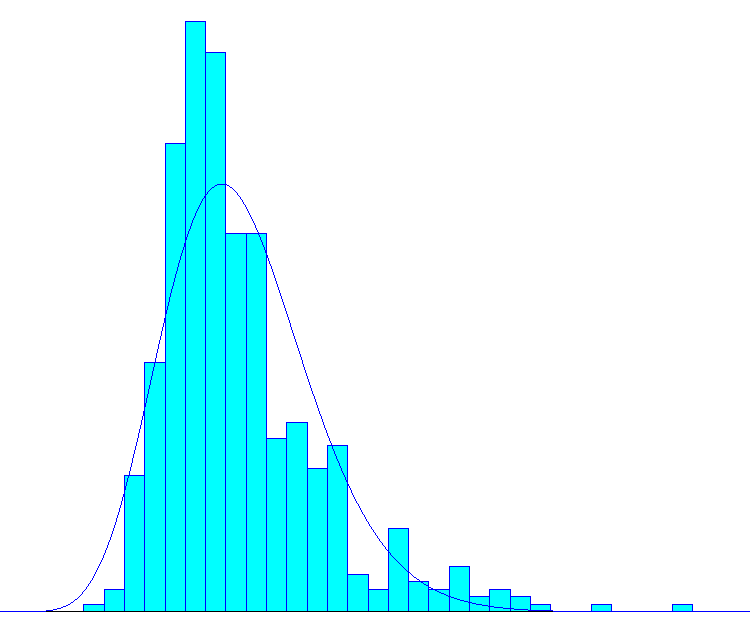

In [16]:
from IPython.display import Image
from IPython.core.display import HTML

Image(filename="Gamma fit arena.png", width=400)

I decided to test another API for Scipy to make sure I was not using wrong syntax. In addition the Fitter package allowes me to check some other distributions on the data and see which one fits it the best.

,sumsquare_error,aic,bic,kl_div
lognorm,17570.475089,-454.153213,1497.315330,inf
beta,18511.714904,-440.200485,1523.523660,inf
gamma,18536.666325,-443.481899,1518.085277,inf
norm,35750.627796,-283.578861,1766.969305,inf


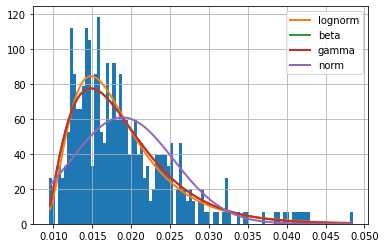

In [18]:
df_hist_two = descr_statistics.loc["std"].to_frame()
f = Fitter(df_hist_two, distributions=["lognorm", "gamma", "beta", "norm"])
f.fit()
f.summary()

Because this second attempt did not lead to a better fit of the gamma distribution to the data, I decided to use a different distribution instead. Among the common distributions lognorm seems to fit the data the best. I proceed by plotting the distribution of standard deviations and a lognorm fit of this distribution.

In [19]:
sample_line = np.linspace(df_hist_two["std"].min(), df_hist_two["std"].max(), 100,)
params = stats.lognorm.fit(df_hist_two["std"])
probab_two = stats.lognorm.pdf(sample_line, params[0], params[1], params[2])

fig_six = px.histogram(df_hist_two, x="std", histnorm="probability density")
fig_six.add_trace(
    go.Scatter(x=sample_line, y=probab_two, mode="lines", name="Lognorm fit")
)
fig_six.update_layout(
    title="Distribution of the standard deviation values with a fitted Lognorm distribution."
)
# print(params)
fig_six.show()

Next, I run a summary on my mean and std vector. The df is retained for later use.

In [20]:
descr_statistics_trans = descr_statistics.transpose()
add_descr_data = descr_statistics_trans[["mean", "std"]].describe()
show_more(add_descr_data, 8, 2)

,mean,std
count,388.000000,388.000000
mean,0.001287,0.018863
std,0.001040,0.006559
min,-0.001070,0.009370
25%,0.000582,0.014192
50%,0.001264,0.017415
75%,0.001901,0.021736
max,0.007374,0.048515


This is where I prepare the data for the next graphs. This includes grouping them by SIGC Sector and Sub Industry and aggregating their data. In addition I calculate the centroids for GICS Sectors and Sub industries and the average distance from these centroids. This will help us get a clearer picture of the many data points in the next few plots.

In [26]:
info_descr_data = pd.concat(
    [SP500_info, descr_statistics_trans], axis=1, sort=False, join="inner"
)
info_descr_data = (
    info_descr_data.reset_index()
    .rename(columns={"index": "Symbol"})
    .set_index("Symbol")
)


# Calculate position of center of GICS Sector and GICS Sub insdustry respectively
piv_info_descr_data_GICS = pd.pivot_table(
    info_descr_data, index="GICS Sector", values=["mean", "std"], aggfunc=np.mean
)
piv_info_descr_data_GICS_sub = pd.pivot_table(
    info_descr_data, index="GICS Sub-Industry", values=["mean", "std"], aggfunc=np.mean
)

# merge position of center of GICS Sector and GICS Sub insdustry respectively into our df
info_descr_data = info_descr_data.reset_index().merge(
    piv_info_descr_data_GICS, on="GICS Sector", suffixes=("", "_GICS_Sector")
)
info_descr_data = info_descr_data.merge(
    piv_info_descr_data_GICS_sub,
    on="GICS Sub-Industry",
    suffixes=("", "_GICS_Sub_Industry"),
)

# Calculate the distance from the center of GICS Sector and Sub Industry for every point
info_descr_data["distance_from_centroid_GICS_Sector"] = (
    (info_descr_data["mean"] - info_descr_data["mean_GICS_Sector"]) ** 2
    + (info_descr_data["std"] - info_descr_data["std_GICS_Sector"]) ** 2
) ** (1 / 2) + 0.0001
info_descr_data["distance_from_centroid_GICS_Sub_Industry"] = (
    (info_descr_data["mean"] - info_descr_data["mean_GICS_Sub_Industry"]) ** 2
    + (info_descr_data["std"] - info_descr_data["std_GICS_Sub_Industry"]) ** 2
) ** (1 / 2) + 0.0001

# Calculate mean distance from the center of GICS Sector and Sub Industry for every point
piv_info_descr_data_GICS_dist = pd.pivot_table(
    info_descr_data,
    index="GICS Sector",
    values=["distance_from_centroid_GICS_Sub_Industry"],
    aggfunc=np.mean,
)
piv_info_descr_data_GICS_dist_sub = pd.pivot_table(
    info_descr_data,
    index="GICS Sub-Industry",
    values=["distance_from_centroid_GICS_Sub_Industry"],
    aggfunc=np.mean,
)

# merge average distance of center of GICS Sector and GICS Sub insdustry respectively into our df
info_descr_data = info_descr_data.reset_index().merge(
    piv_info_descr_data_GICS_dist,
    on="GICS Sector",
    suffixes=("", "_GICS_Sector_distance"),
)
info_descr_data = info_descr_data.reset_index().merge(
    piv_info_descr_data_GICS_dist_sub,
    on="GICS Sub-Industry",
    suffixes=("", "_GICS_Sector_distance_sub"),
)
# show_more(info_descr_data, 5, 21)

The next two plots depict the average positions and spreads of GICS Sectors and Sub Sectors. We will have a look at the complete plots afterwards. 

The spread of the Sectors is calculated as the Euclidean Distance from the average point of that cluster plus a very small constant to keep Sub industries with only one member visible. This value is illustrated as the size of these average positions. This is not optimal, because the Subindustries with a small spread are actually more interesting when trying to find patterns in the data. Nevertheless, this is the most straightforward and in some way intuitive way of depicting the spread. In addition to the normal markings, I included a grey horizontal and vertical line which respectively indicate the average standard deviation and mean of all points, to make comparing the four graphs easier.

In [27]:
fig = px.scatter(
    info_descr_data,
    x="std_GICS_Sector",
    y="mean_GICS_Sector",
    color="GICS Sector",
    size="distance_from_centroid_GICS_Sub_Industry_GICS_Sector_distance",
)
fig.update_layout(
    title="Average daily mean and standard deviation of log returns and <br>average distance from centroid for the S&P500",
    shapes=[
        dict(
            type="line",
            yref="paper",
            y0=0,
            y1=1,
            xref="x",
            x0=add_descr_data.loc["mean"]["std"],
            x1=add_descr_data.loc["mean"]["std"],
            fillcolor="white",
            opacity=0.1,
        ),
        dict(
            type="line",
            yref="y",
            y0=add_descr_data.loc["mean"]["mean"],
            y1=add_descr_data.loc["mean"]["mean"],
            xref="paper",
            x0=0,
            x1=1,
            fillcolor="white",
            opacity=0.1,
        ),
    ],
)
fig.show()

In the above chart it seems like the corona crisis has already had a big impact on the performance of the different sectors. Sectors like Consumer staples, consumer services and utilities all feature above average mean returns and below average standard deviation. Their spread is also not very big when compared with sectors like consumer discretionary and Energy. Energy is an outlier and is has fared the worst of all in both measures. This is because of the very low oil prices and worries over the economic development in the short term.

Health care and Information technology seem to be logical winners of the current circumstances, but technology does is features much more volatile returns than health.

In [31]:
print(info_descr_data["GICS Sector"].unique())

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Discretionary' 'Utilities'
 'Financials' 'Materials' 'Real Estate' 'Consumer Staples' 'Energy']


In [33]:

# def pick_sub_industry(sector): 
@interact
def pick_sub_industry(sector=info_descr_data["GICS Sector"].unique()):
    displayed_sector_mask = info_descr_data["GICS Sector"].isin([sector])
    df_scat_two = info_descr_data[displayed_sector_mask]
    fig2 = px.scatter(
        df_scat_two,
        x="std_GICS_Sub_Industry",
        y="mean_GICS_Sub_Industry",
        color="GICS Sub-Industry",
        size="distance_from_centroid_GICS_Sub_Industry_GICS_Sector_distance_sub",
    )
    t = np.linspace
    fig2.update_layout(
        title="Average of daily mean and standard deviation of log returns and <br>average distance from centroid for the {} sector".format(
            sector
        ),
        shapes=[
            dict(
                type="line",
                yref="paper",
                y0=0,
                y1=1,
                xref="x",
                x0=add_descr_data.loc["mean"]["std"],
                x1=add_descr_data.loc["mean"]["std"],
                fillcolor="white",
                opacity=0.1,
            ),
            dict(
                type="line",
                yref="y",
                y0=add_descr_data.loc["mean"]["mean"],
                y1=add_descr_data.loc["mean"]["mean"],
                xref="paper",
                x0=0,
                x1=1,
                fillcolor="white",
                opacity=0.1,
            ),
        ],
    )
    fig2.show()

# pick_sub_industry('Communication Services')

interactive(children=(Dropdown(description='sector', options=('Industrials', 'Health Care', 'Information Techn…

Next, I will have a look at the complete points instead of the centroids of the clusters. They are colored according to their Sectors and we can clearly see that the simplicity of the plots before is deceptive. It is actually really hard to see what is going on in these plots. Still if we filter the data by clicking on the legend, we see that our insights from above roughly hold.

In [29]:
df_scat_one = info_descr_data
fig1 = px.scatter(
    df_scat_one,
    x="std",
    y="mean",
    color="GICS Sector",
    hover_data=["Security", "Symbol", "GICS Sub-Industry"],
)
fig1.update_layout(
    title="Daily mean and standard deviation of log returns for the S&P500",
    shapes=[
        dict(
            type="line",
            yref="paper",
            y0=0,
            y1=1,
            xref="x",
            x0=add_descr_data.loc["mean"]["std"],
            x1=add_descr_data.loc["mean"]["std"],
            fillcolor="white",
            opacity=0.1,
        ),
        dict(
            type="line",
            yref="y",
            y0=add_descr_data.loc["mean"]["mean"],
            y1=add_descr_data.loc["mean"]["mean"],
            xref="paper",
            x0=0,
            x1=1,
            fillcolor="white",
            opacity=0.1,
        ),
    ],
)
fig1.show()

In [34]:
@interact
def pick_sub_industry(sector=info_descr_data["GICS Sector"].unique()):
    displayed_sector_mask = info_descr_data["GICS Sector"].isin([sector])
    df_scat_two = info_descr_data[displayed_sector_mask]
    fig2 = px.scatter(
        df_scat_two,
        x="std",
        y="mean",
        color="GICS Sub-Industry",
        hover_data=["Security", "Symbol"],
    )
    t = np.linspace
    fig2.update_layout(
        title="Daily mean and standard deviation of log returns for the {} sector".format(
            sector
        ),
        shapes=[
            dict(
                type="line",
                yref="paper",
                y0=0,
                y1=1,
                xref="x",
                x0=add_descr_data.loc["mean"]["std"],
                x1=add_descr_data.loc["mean"]["std"],
                fillcolor="white",
                opacity=0.1,
            ),
            dict(
                type="line",
                yref="y",
                y0=add_descr_data.loc["mean"]["mean"],
                y1=add_descr_data.loc["mean"]["mean"],
                xref="paper",
                x0=0,
                x1=1,
                fillcolor="white",
                opacity=0.1,
            ),
        ],
    )
    fig2.show()

interactive(children=(Dropdown(description='sector', options=('Industrials', 'Health Care', 'Information Techn…

##### 4. CAPM analysis

In this section I will run a simple linear regression model on the log returns of single stocks and the SP500 as a simple CAPM model. 

I just realized, that the task speaks about returns and not log returns. I assume that log returns is meant as we have worked with these so far. Should this not be the case please change the "should_be_log_returns" variable from True to False. This will the trigger a recalculation of regular returns and the remaining analysis will be conducted with regular returns. Please keep in mind that my analysis will be concerned with the scenario of log returns.

In [35]:
should_be_log_returns = True

This is a simple variation on the calc_log_returns function and calculates regular returns.

In [36]:
def calc_nrm_returns(df):
    """
    calculates a df of day-on-day returns for the df that was given as input
    """
    if type(df) == pd.core.frame.DataFrame:
        columns = list(df.columns.values)
    elif type(df) == pd.core.series.Series:
        df = df.to_frame()
        columns = list(df.columns.values)
    else:
        return print("The input must be a pandas df or series object")
    # end of type checks
    nrm_returns = pd.DataFrame(index=df.index)
    for i, column in log_progress(
        enumerate(columns), size=len(columns), name="tickers"
    ):
        nrm_returns[column] = (df[column]) - (df[column].shift(1))
    print("Finished calculating nrm returns")
    return nrm_returns

This function will allow us to fetch the SP500 data and add it to the df with the remaining companies. It also calculates the SP500 returns (log or otherwise) and ads them to the correct df.

In [37]:
def add_SP500(log_returns_bool):
    """
    Fetches SP500 data and calculates log or regular returns based on input log_returns_bool.
    Afterwards the data is merged into df with remaining 500 companies.
    """
    # Fetch SP500 data
    SP_index_data_init = get_stock_data("^GSPC", start_date_query, end_date_query)
    if log_returns_bool == True:
        # Calculate log returns and insert in corresponding df
        SP_index_data_log = calc_log_returns(SP_index_data_init.transpose()).rename(
            columns={"^GSPC": "GSPC"}
        )[1:]
        log_returns_price_SP = pd.concat(
            [log_returns_price, SP_index_data_log], axis=1, sort=False, join="inner"
        )
        log_returns_price_SP.columns = log_returns_price_SP.columns.str.replace(
            "-", "_"
        )
        return log_returns_price_SP
    else:
        nrm_returns_price = calc_nrm_returns(price_data)[1:]
        # Calculate nrm returns and insert in corresponding df
        SP_index_data_nrm = calc_nrm_returns(SP_index_data_init.transpose()).rename(
            columns={"^GSPC": "GSPC"}
        )[1:]
        nrm_returns_price_SP = pd.concat(
            [nrm_returns_price, SP_index_data_nrm], axis=1, sort=False, join="inner"
        )
        nrm_returns_price_SP.columns = nrm_returns_price_SP.columns.str.replace(
            "-", "_"
        )
        return nrm_returns_price_SP

Now we run the simple model for all tickers in the df and save the results to a new df. Note that I used the statsmodels "formula API" which is more similar to the way models are created in R.

In [38]:
%%time
returns_price_SP = add_SP500(should_be_log_returns)
def run_model(returns_price_SP):
    '''
    Takes in a df containing returns for a number of tickers including the ticker against whcih they are to be regressed 
    and returns a df containing the alpha, beta and p-alpha value.
    '''
    reg_data = pd.DataFrame(columns=["name", "alpha", "beta", "p_alpha"])
    print("SP500 data fetched. Start regressing the tickers against the SP500.")
    for i, ticker in log_progress( enumerate(returns_price_SP.columns), size=len(returns_price_SP.columns), name="tickers"):
        if ticker.replace("^", "") != "GSPC":
            results_formula = sm1.ols(
                formula=ticker.replace("^", "") + " ~ GSPC", data=returns_price_SP
            ).fit()
            alpha, beta = results_formula.params
            p_alpha = results_formula.pvalues[0]
            reg_data.loc[i] = [ticker, alpha, beta, p_alpha]
    reg_data = reg_data.set_index("name")
    return reg_data
reg_data = run_model(returns_price_SP)


[*********************100%***********************]  1 of 1 completed


SP500 data fetched. Start regressing the tickers against the SP500.


Wall time: 10.7 s


The next two graphs show the distribution of alpha and beta values of our model. They are fitted with a normal curve just like the examples in the beginning of the notebook. In both cases, the normal curve seems a reasonable fit for the data.

In [39]:
reg_mask = reg_data["beta"].notnull()
reg_data_beta = reg_data[reg_mask]

sample_line = np.linspace(reg_data_beta["beta"].min(), reg_data_beta["beta"].max(), 100)
mu_mean, std_mean = stats.norm.fit(reg_data_beta["beta"])
probab_three = stats.norm.pdf(sample_line, mu_mean, std_mean)

fig = px.histogram(reg_data_beta, x="beta", histnorm="probability density")
fig.add_trace(
    go.Scatter(x=sample_line, y=probab_three, mode="lines", name="Normal fit")
)
fig.update_layout(
    title="Distribution of beta values with a fitted normal distribution."
)
fig.show()

In [40]:
reg_mask = reg_data["alpha"].notnull()
reg_data_alpha = reg_data[reg_mask]

sample_line = np.linspace(
    reg_data_alpha["alpha"].min(), reg_data_alpha["alpha"].max(), 100
)
mu_mean, std_mean = stats.norm.fit(reg_data_alpha["alpha"])
probab = stats.norm.pdf(sample_line, mu_mean, std_mean)

fig = px.histogram(reg_data_beta, x="alpha", histnorm="probability density")
fig.add_trace(go.Scatter(x=sample_line, y=probab, mode="lines", name="Normal fit"))
fig.update_layout(
    title="Distribution of alpha values with a fitted normal distribution."
)

fig.show()

The next graph was not asked for in the task but seemed interesting to me. In it I plot the different stocks and their alpha and beta values. A color scale indicates the p value of the alpha. Most stocks cluster around an alpha of 0 which is expected and are located between a beta of 0.5 and 1.5, which is not surprising either. p values close to alpha = 0 tend to be quiet high, while those further from 0 become more significant. Again this is not very surprising.

I also added a simple OLS regression line to the plot, which indicates a moderate negative correlation between alpha and beta. This still holds true when we restrict the displayed values to those with high p values for alpha by using the "hurdle slider". This negative correlation is at least noteworthy. It indicates that companies with high betas, meaning a high reaction to market movements have underperformed the benchmark, while those with lower betas have outperformed the market. Of course these are only tendencies. One explanation of this trend is that the corona related crash of the markets has hit discretionary spending out of proportion. On the other hand solid companies with low betas may have even won because of being seen as safehavens from the current volatility, driving them to outperform the market.

This thesis seems in line with our observations in the mean-standard deviation graphs, where sectors like consumer services, utilities and consumer staples all featured above average means and below average standard deviations of log returns.

In [41]:
@interact_manual
def pick_hurdle(hurdle=(0.01, 1, 0.01)):
    df_extreme_values = (
        pd.concat([reg_data, SP500_info], axis=1, join="inner")
        .reset_index()
        .rename(columns={"index": "name"})
    )
    p_alpha_mask = df_extreme_values["p_alpha"] < hurdle
    df_extreme_values_scat = df_extreme_values[p_alpha_mask]
    fig3 = px.scatter(
        df_extreme_values_scat,
        x="alpha",
        y="beta",
        color="p_alpha",
        color_continuous_scale=px.colors.sequential.Viridis,
        trendline="ols",
        hover_data=["p_alpha", "name", "Security", "GICS Sector"],
    )
    fig3.update_layout(
        title="Alphas and betas for stocks in the the S&P500, for p values of alpha smaller than {}".format(
            hurdle
        )
    )
    fig3.show()

interactive(children=(FloatSlider(value=0.5, description='hurdle', max=1.0, min=0.01, step=0.01), Button(descr…

I think that the graph above should be sufficient to pick out an interesting company to discuss, but to be explicit, I will show the biggest and smallest values for both alpha and beta below.

In [42]:
df_extreme_values = (
    pd.concat([reg_data, SP500_info], axis=1, join="inner")
    .reset_index()
    .rename(columns={"index": "name"})
).set_index("name")

These are the companies with the smallest beta values.

In [43]:
show_more(df_extreme_values.sort_values(by=["beta"]).iloc[:5], 5, 11)

,alpha,beta,p_alpha,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
name,,,,,,,,,,,
CLX,-0.000926,-0.138240,0.373721,Clorox,reports,Consumer Staples,Household Products,"Oakland, California",1969-03-31,21076,1913
KR,0.000552,0.094103,0.630564,Kroger,reports,Consumer Staples,Food Retail,"Cincinnati, Ohio",1957-03-04,56873,1883
CPB,-0.000441,0.160024,0.620020,Campbell Soup,reports,Consumer Staples,Packaged Foods & Meats,"Camden, New Jersey",1957-03-04,16732,1869
KMB,-0.000557,0.180676,0.441023,Kimberly-Clark,reports,Consumer Staples,Household Products,"Irving, Texas",1957-03-04,55785,1872
CHD,-0.000541,0.181275,0.450358,Church & Dwight,reports,Consumer Staples,Household Products,"Ewing, New Jersey",2015-12-29,313927,1847


These are the companies with the lowest beta values.

In [44]:
show_more(df_extreme_values.sort_values(by=["beta"]).iloc[-5:], 5, 11)

,alpha,beta,p_alpha,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
name,,,,,,,,,,,
LRCX,0.000465,1.812050,0.731916,Lam Research,reports,Information Technology,Semiconductor Equipment,"Fremont, California",2012-06-29,707549,1980
MCHP,-0.000207,1.866349,0.845317,Microchip Technology,reports,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054,1989
AMAT,0.001256,1.912852,0.335903,Applied Materials,reports,Information Technology,Semiconductor Equipment,"Santa Clara, California",1995-03-16,6951,1967
PENN,-0.002288,2.020585,0.295149,Penn National Gaming,reports,Consumer Discretionary,Casinos & Gaming,"Wyomissing, Pennsylvania",2021-03-22,921738,1972
CZR,0.000194,2.121115,0.907838,Caesars Entertainment,reports,Consumer Discretionary,Casinos & Gaming,"Reno, Nevada",2021-03-22,1590895,1973


Now to the five companies with the highest alpha values given that the p-value of their alpha is below the 5% hurdle.

In [45]:
show_more(
    df_extreme_values[df_extreme_values["p_alpha"] <= 0.05]
    .sort_values(by=["alpha"], ascending=False)
    .iloc[-6:],
    6,
    11,
)

,alpha,beta,p_alpha,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
name,,,,,,,,,,,
MRNA,0.006624,0.765186,0.031803,Moderna,reports,Health Care,Biotechnology,"Cambridge, Massachusetts",2021-07-21,1682852,2010
IT,0.002457,1.056321,0.027931,Gartner,reports,Information Technology,IT Consulting & Other Services,"Stamford, Connecticut",2017-04-05,749251,1979
CRL,0.001765,0.992403,0.046581,Charles River Laboratories,reports,Health Care,Life Sciences Tools & Services,"Wilmington, Massachusetts",2021-05-14,1100682,1947
GRMN,0.001197,0.964496,0.041397,Garmin,reports,Consumer Discretionary,Consumer Electronics,"Schaffhausen, Switzerland",2012-12-12,1121788,1989


Next, I will show the five companies with the lowest alpha values given that the p-value of their alpha is below the 5% hurdle.

In [46]:
show_more(
    df_extreme_values[df_extreme_values["p_alpha"] <= 0.05]
    .sort_values(by=["alpha"], ascending=False)
    .iloc[:5],
    5,
    11,
)

,alpha,beta,p_alpha,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
name,,,,,,,,,,,
MRNA,0.006624,0.765186,0.031803,Moderna,reports,Health Care,Biotechnology,"Cambridge, Massachusetts",2021-07-21,1682852,2010
IT,0.002457,1.056321,0.027931,Gartner,reports,Information Technology,IT Consulting & Other Services,"Stamford, Connecticut",2017-04-05,749251,1979
CRL,0.001765,0.992403,0.046581,Charles River Laboratories,reports,Health Care,Life Sciences Tools & Services,"Wilmington, Massachusetts",2021-05-14,1100682,1947
GRMN,0.001197,0.964496,0.041397,Garmin,reports,Consumer Discretionary,Consumer Electronics,"Schaffhausen, Switzerland",2012-12-12,1121788,1989


#### What would I invest in?

We have seen in the graphs concerned with the mean and standard deviation of the log returns of the firms in the SP500 that the corona crisis has already had a big impact on the stock market. This was true both on an individual firm level and on aggregated levels of GICS Sectors and Sub industries. So far things that could be refered to as luxury goods have suffered the most. Subsectors depending on consumer discretionary spending like travel and hotel, apparel retail or even casino gambling have had returns far below the overall average and were much more volatile at the same time. 

On the other hand communication services like home entertainmend, cable and telecoms and others have performed comparatively well throughout the past months. Apart from healthcare supplies and facilities where companies performances were fairly spread, the health care sector has also performed well. 

If we can take anything from this look at mean log returns and their standard deviation, its that there could be three different categories of companies which could be worth investing in.
1. On a high level those are robust big companies who do not depend on discretionary spending like utilities which could become more attractive now that more spectacular more volatile companies have performed so bad.
2. Second, there are sectors like the health care sector or certain parts of the technology sectors which inherently stand to profit from the current circumstances, because they fill a nee which was not foreseeable before.
3. Lastly, it is imaginable that some companies in sectors which crashed during the past months, were drawn with their peers "unfairly". They might have solid financials and may be less exposed to losses in revenue than we currently believe. Accordingly, they can be expected catch up with the broader market again.

Our simple CAPM modell allows us to identify companies of the first kind and second kind as well as companies which might stand out apart from their sector.

When we look at the five companies with the lowest betas, we see that four of them belong to the consumer staples sector and three of them are directly concerned with food. This implies that this sector might be worth investing in as a safe, robust group of companies who going to loose a lot but are unlikely to gain a lot as well.

Among the highest betas, there are companies concerned with travel and holidays. This is no surprise given the many restrictions imposed by corona. At the same time there might be some such companies who do not have high running costs and have solid balance sheets. They could profit from the consolidation which is bound to occur in this sector. There could be very attractive companies for investors in this group.

Lastly, the significant low alpha values do not show an easy to understand pattern. They come from different industries and do not seem connected.
The case for companies with high alpha values seems similar. It is however obvious that technology plays a big role. Else, these companies (Microsoft and Apple among others) do not seem very surprising. 

It seems like we may be able to make reasonable decisions, which industries to invest into based on our analysis of their mean log returns and their betas. It is not surprising that it is not possible to make clear predictions as to which companies might produce dependable alphas in the future. If this were easy, most of the financial industry would not exist.

Lastly, we can choose one stock to display his log returns against those of the SP500 below. I added a regression line based on a simple linear regression and marginal historgrams because I felt it was hard to estimate the desnsity of points where they cluster around the origin in the scatter plot.

In [47]:
@interact
def pick_stock(stock=returns_price_SP.columns):
    stock_name = SP500_info.loc()[stock]["Security"]
    displayed_stock = stock
    df_scat_three = returns_price_SP.reset_index()
    df_scat_three["Date"] = df_scat_three["Date"].dt.strftime("%m-%d-%Y")
    fig3 = px.scatter(
        df_scat_three,
        x="GSPC",
        y=displayed_stock,
        trendline="ols",
        hover_data=["Date"],
        marginal_x="histogram",
        marginal_y="histogram",
    )
    fig3.update_layout(
        title="Daily mean of log returns for {} - {} and the S&P500".format(
            stock_name, stock
        )
    )
    fig3.show()

interactive(children=(Dropdown(description='stock', options=('MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADB…

Below we see the distribution of log returns for the SP500. They are fitted with a normal curve and a student-t distribution. As predicted, the normal curve is too flat and cannot capture the many extreme values of the SP500. The Student-t seems a reasonable fit and did not pose any difficulties in pyhton as was predicted it could in the task.

In [48]:
sample_line = np.linspace(
    returns_price_SP["GSPC"].min(), returns_price_SP["GSPC"].max(), 1000
)

mu_GSPC, std_GSPC = stats.norm.fit(returns_price_SP["GSPC"])
norm_probab_GSPC = stats.norm.pdf(sample_line, mu_GSPC, std_GSPC)

df_GSPC, loc_GSPC, scale_GSPC = stats.t.fit(returns_price_SP["GSPC"])
t_probab_GSPC = stats.t.pdf(sample_line, df_GSPC, loc_GSPC, scale_GSPC)

fig = px.histogram(returns_price_SP, x="GSPC", histnorm="probability density")
fig.add_trace(
    go.Scatter(x=sample_line, y=norm_probab_GSPC, mode="lines", name="Normal fit")
)
print(
    "Parameters of the Normal function are mu: {} and std: {}.".format(
        round(mu_GSPC, 4), round(std_GSPC, 4)
    )
)
fig.add_trace(
    go.Scatter(x=sample_line, y=t_probab_GSPC, mode="lines", name="Student-t fit")
)
print(
    "Parameters of the Student-t function are v: {}, loc: {}  and scale: {}.".format(
        round(df_GSPC, 4), round(loc_GSPC, 4), round(scale_GSPC, 4)
    )
)
fig.update_layout(
    title="Distribution of the SP500 log returns with a fitted Nomal and Student-t distribution."
)
fig.show()

Parameters of the Normal function are mu: 0.0011 and std: 0.0088.
Parameters of the Student-t function are v: 6.0648, loc: 0.0014  and scale: 0.0072.
